In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
import skimage
from skimage.transform import resize
import cv2
import glob
from glob import glob
import imageio
import os

In [2]:
#Loading data sets
path_t1 = 'D:\Data Science\Main Course\Capstone Project\main project\Tr1\TrainT1'
img_t1 = []
for img in glob(path_t1+'/*.png'):
    img_array = cv2.imread(img)
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
    img_t1.append(img_array)

In [3]:
#Checking for shape
img_t1 = np.array(img_t1)
img_t1[0].shape

(217, 181)

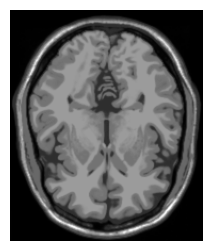

In [4]:
#visualizing data_t1
plt.figure(figsize=(3,3))
plt.axis('off')
plt.imshow(img_t1[0], cmap= 'gray')
plt.show()

In [5]:
#Loading t2 data
path_t2 = 'D:\Data Science\Main Course\Capstone Project\main project\Tr2\TrainT2'
img_t2 = []
for img in glob(path_t2+'/*.png'):
    img_array = cv2.imread(img)
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
    img_t2.append(img_array)

In [6]:
#Checking for shape
img_t2 = np.array(img_t2)
img_t2[0].shape

(217, 181)

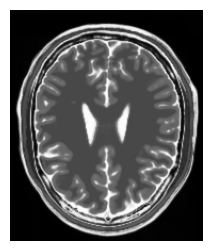

In [7]:
#Visualizing t2 data
plt.figure(figsize=(3,3))
plt.axis('off')
plt.imshow(img_t2[0], cmap= 'gray')
plt.show()

In [8]:
#Batch size
BATCH_SIZE = 5

In [9]:
data_t1 = np.zeros((img_t1.shape[0], 256, 256))
for index, img in enumerate(img_t1):
    data_t1[index, :, :] = resize(img, (256, 256))
data_t1.shape

(43, 256, 256)

In [10]:
data_t2 = np.zeros((img_t2.shape[0], 256, 256))
for index, img in enumerate(img_t2):
    data_t2[index, :, :] = resize(img, (256, 256))
data_t2.shape

(46, 256, 256)

In [11]:
data_t1 = data_t1.reshape(data_t1.shape[0], 256, 256, 1).astype('float32')
data_t2 = data_t2.reshape(data_t2.shape[0], 256, 256, 1).astype('float32')

In [12]:
#Reshuffling data
data_t1 = tf.data.Dataset.from_tensor_slices(data_t1).shuffle(len(data_t1), seed= 42).batch(BATCH_SIZE)
data_t2 = tf.data.Dataset.from_tensor_slices(data_t2).shuffle(len(data_t2), seed= 42).batch(BATCH_SIZE)

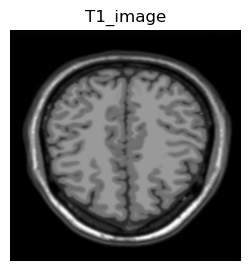

In [13]:
sample_t1_data = next(iter(data_t1))
plt.figure(figsize= (3,3))
plt.imshow(sample_t1_data[0], cmap= 'gray')
plt.title('T1_image')
plt.axis('off')
plt.show()

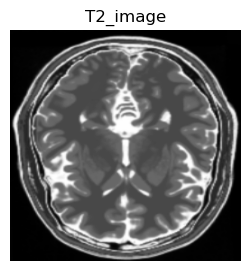

In [14]:
sample_t2_data = next(iter(data_t2))
plt.figure(figsize= (3,3))
plt.imshow(sample_t2_data[0], cmap= 'gray')
plt.title('T2_image')
plt.axis('off')
plt.show()

In [15]:
#Model Building
#Using instance normalization
class InstanceNormalization(tf.keras.layers.Layer):
    # Initialization of Objects
    def __init__(self, epsilon=1e-5):
        # calling parent's init
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    
    def call(self, x):
        # Compute Mean and Variance, Axes=[1,2] ensures Instance Normalization
        mean, variance = tf.nn.moments(x, axes=[1, 2, 3], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

In [16]:
#Downsampling
def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # Add Conv2d layer
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    # Add Normalization layer
    if apply_norm:
        result.add(InstanceNormalization())
    # Add Leaky Relu Activation
    result.add(tf.keras.layers.LeakyReLU())
    return result

In [17]:
#Upsampling
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # Add Transposed Conv2d layer
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    # Add Normalization Layer
    result.add(InstanceNormalization())
    # Conditionally add Dropout layer
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    # Add Relu Activation Layer
    result.add(tf.keras.layers.ReLU())
    return result

In [18]:
#Unet Architecture
def unet_generator():
    down_stack = [
        downsample(64, 4, False), 
        downsample(128, 4), 
        downsample(128, 4), 
        downsample(128, 4),
        downsample(128, 4),
        downsample(128, 4),
        downsample(128, 4),
        downsample(128, 4),
    ]
    up_stack = [
        upsample(128, 4, True), 
        upsample(128, 4, True), 
        upsample(128, 4, True),
        upsample(128, 4, True),
        upsample(128, 4),
        upsample(128, 4),
        upsample(64, 4)
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh')
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[256, 256, 1])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [19]:
#Defining Gnerators
generator_g = unet_generator()
generator_f = unet_generator()

In [20]:
generator_g.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128, 128, 64) 1024        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64, 64, 128)  131328      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 32, 32, 128)  262400      sequential_1[0][0]               
______________________________________________________________________________________________

In [21]:
#Defining Discriminator
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    # add input layer of size (256, 256, 3)
    inp = tf.keras.layers.Input(shape=(256, 256, 1), name='input_image')
    x = inp
    
    # add downsampling step here
    down1 = downsample(64, 4, False)(x) 
    down2 = downsample(128, 4)(down1) 
    # add a padding layer here
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down2) 
    
    # implement a concrete downsampling layer here
    conv = tf.keras.layers.Conv2D(256, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) 
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    
    # apply zero padding layer
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) 
    
    # add a last pure 2D Convolution layer
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) 
    return tf.keras.Model(inputs=inp, outputs=last)

In [22]:
discriminator_x = discriminator()
discriminator_y = discriminator()

In [23]:
discriminator_x.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 256, 256, 1)]     0         
_________________________________________________________________
sequential_30 (Sequential)   (None, 128, 128, 64)      1024      
_________________________________________________________________
sequential_31 (Sequential)   (None, 64, 64, 128)       131328    
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 66, 66, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 63, 63, 256)       524288    
_________________________________________________________________
instance_normalization_29 (I (None, 63, 63, 256)       512       
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 63, 63, 256)       0   

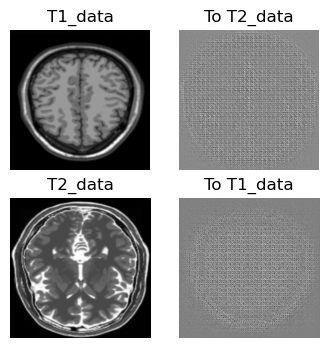

In [24]:
to_t1_data = generator_g(sample_t1_data)
to_t2_data = generator_f(sample_t2_data)
plt.figure(figsize=(4, 4))

imgs = [sample_t1_data, to_t2_data, sample_t2_data, to_t1_data]
title = ['T1_data', 'To T2_data', 'T2_data', 'To T1_data']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    plt.imshow(imgs[i][0].numpy()[:, :, 0], cmap= 'gray')
    plt.axis('off')
plt.show()

In [25]:
to_t1_data.shape

TensorShape([5, 256, 256, 1])

In [26]:
#Defining losses
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [27]:
#Discriminator loss
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

In [28]:
#Generator loss
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [29]:
#Cycle loss
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 10.0 * loss1

In [30]:
#Identity loss
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 0.5*loss

In [31]:
#Defining Optimizer
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [32]:
EPOCHS = 40

In [33]:
#Checkpoints
checkpoint_path = "./Trained_Model"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [34]:
#Plotting generated images after each epoch
def generate_images(model1, test_input1, model2, test_input2):
    prediction1 = model1(test_input1)
    prediction2 = model2(test_input2)
    plt.figure(figsize=(8, 4))
    display_list = [test_input1[0], prediction1[0], test_input2[0], prediction2[0]]
    title = ['Input Image', 'Predicted Image', 'Input Image', 'Predicted Image']
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].numpy()[:, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(EPOCHS))
    plt.show()

In [35]:
#Training Workflow
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)
        
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)
        
        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)
        
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)
        
        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        
        # Total generator loss = BCE loss + cycle loss + identity loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        
        # Discriminator's loss
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
        
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)
    
    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

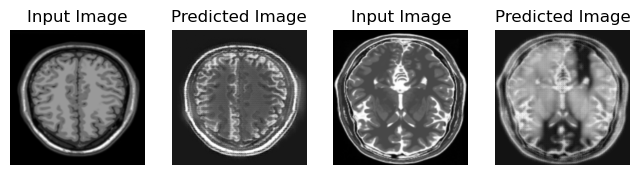

Saving checkpoint for epoch 1 at ./Trained_Model\ckpt-91


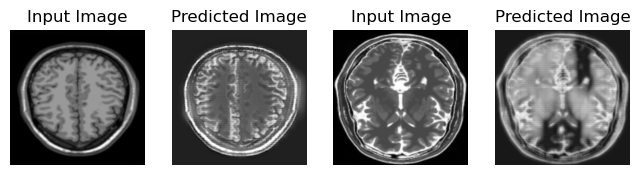

Saving checkpoint for epoch 2 at ./Trained_Model\ckpt-92


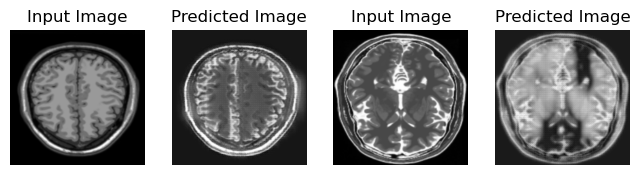

Saving checkpoint for epoch 3 at ./Trained_Model\ckpt-93


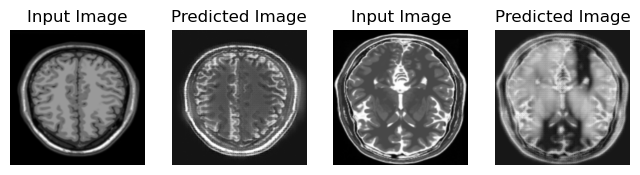

Saving checkpoint for epoch 4 at ./Trained_Model\ckpt-94


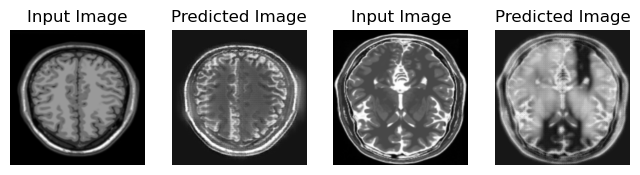

Saving checkpoint for epoch 5 at ./Trained_Model\ckpt-95


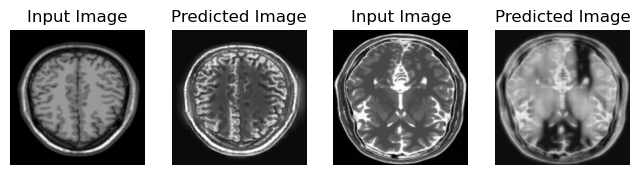

Saving checkpoint for epoch 6 at ./Trained_Model\ckpt-96


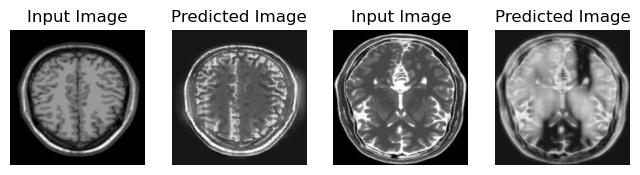

Saving checkpoint for epoch 7 at ./Trained_Model\ckpt-97


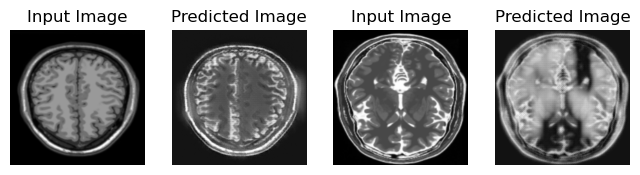

Saving checkpoint for epoch 8 at ./Trained_Model\ckpt-98


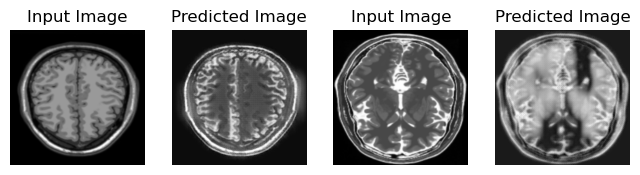

Saving checkpoint for epoch 9 at ./Trained_Model\ckpt-99


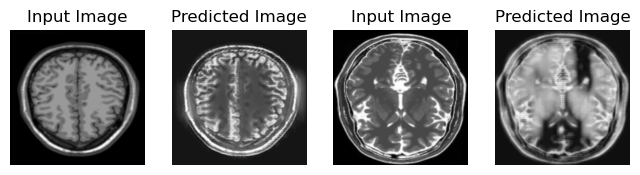

Saving checkpoint for epoch 10 at ./Trained_Model\ckpt-100


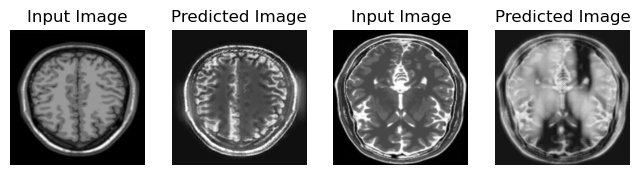

Saving checkpoint for epoch 11 at ./Trained_Model\ckpt-101


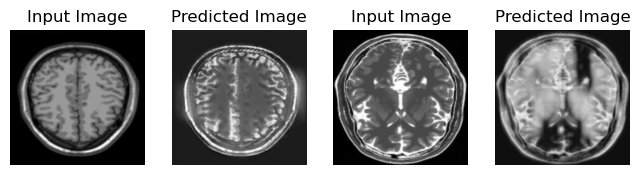

Saving checkpoint for epoch 12 at ./Trained_Model\ckpt-102


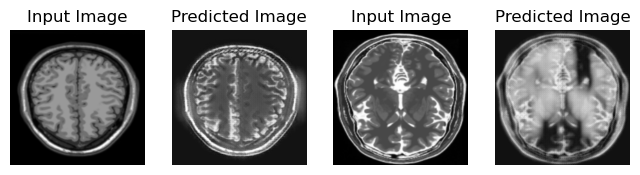

Saving checkpoint for epoch 13 at ./Trained_Model\ckpt-103


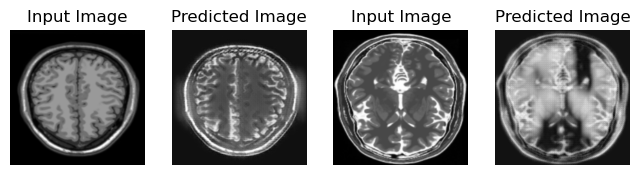

Saving checkpoint for epoch 14 at ./Trained_Model\ckpt-104


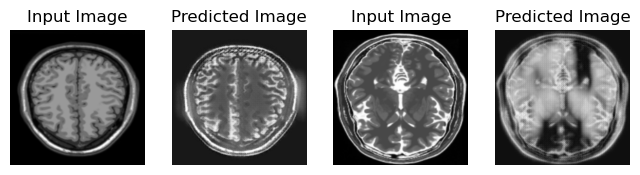

Saving checkpoint for epoch 15 at ./Trained_Model\ckpt-105


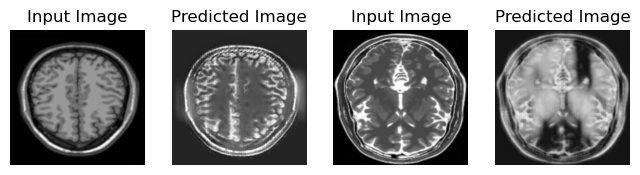

Saving checkpoint for epoch 16 at ./Trained_Model\ckpt-106


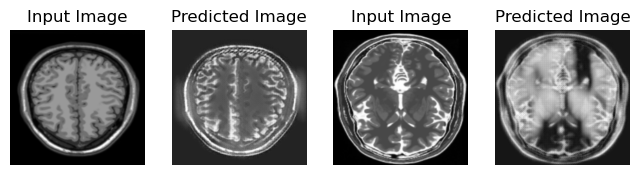

Saving checkpoint for epoch 17 at ./Trained_Model\ckpt-107


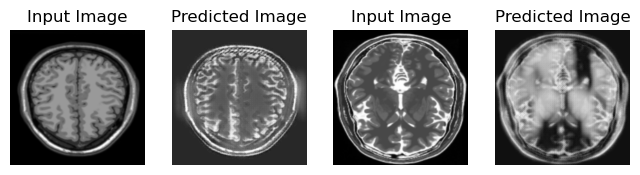

Saving checkpoint for epoch 18 at ./Trained_Model\ckpt-108


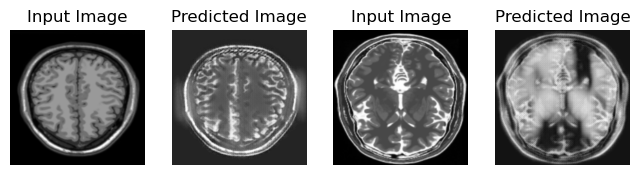

Saving checkpoint for epoch 19 at ./Trained_Model\ckpt-109


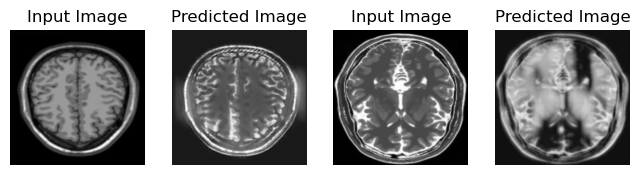

Saving checkpoint for epoch 20 at ./Trained_Model\ckpt-110


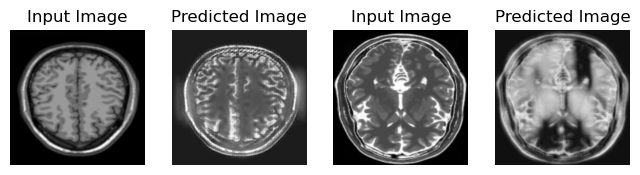

Saving checkpoint for epoch 21 at ./Trained_Model\ckpt-111


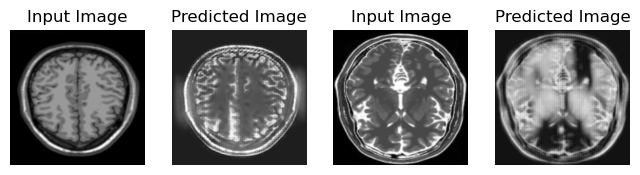

Saving checkpoint for epoch 22 at ./Trained_Model\ckpt-112


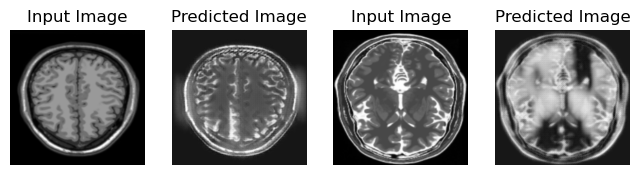

Saving checkpoint for epoch 23 at ./Trained_Model\ckpt-113


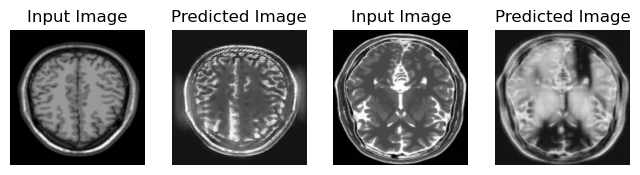

Saving checkpoint for epoch 24 at ./Trained_Model\ckpt-114


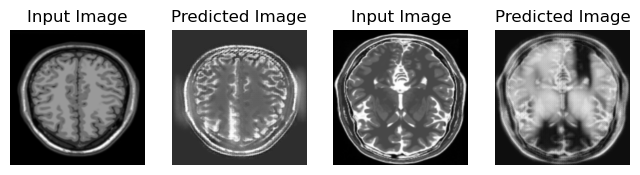

Saving checkpoint for epoch 25 at ./Trained_Model\ckpt-115


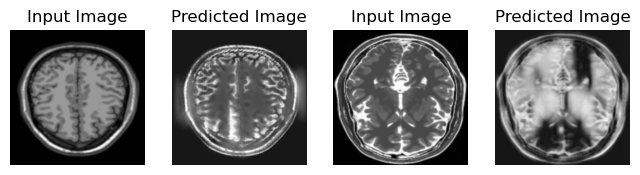

Saving checkpoint for epoch 26 at ./Trained_Model\ckpt-116


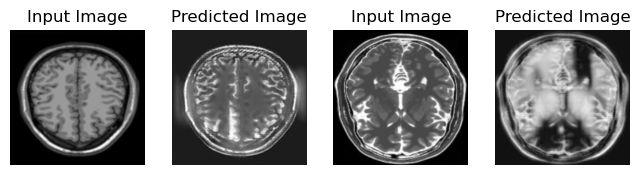

Saving checkpoint for epoch 27 at ./Trained_Model\ckpt-117


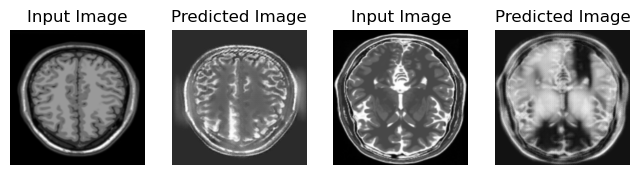

Saving checkpoint for epoch 28 at ./Trained_Model\ckpt-118


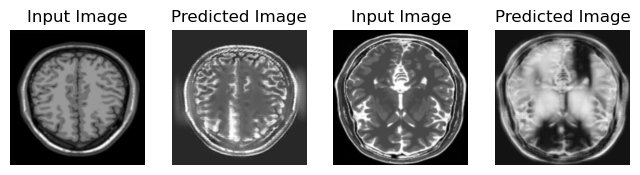

Saving checkpoint for epoch 29 at ./Trained_Model\ckpt-119


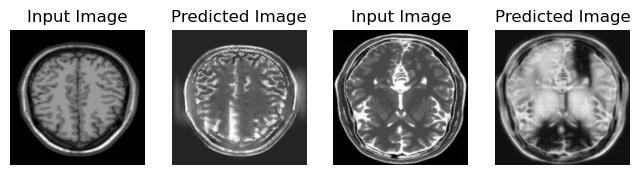

Saving checkpoint for epoch 30 at ./Trained_Model\ckpt-120


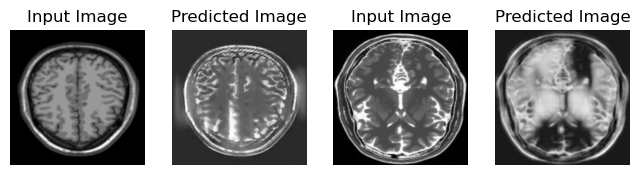

Saving checkpoint for epoch 31 at ./Trained_Model\ckpt-121


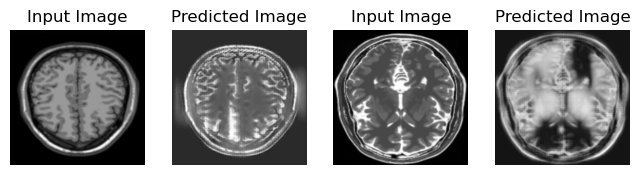

Saving checkpoint for epoch 32 at ./Trained_Model\ckpt-122


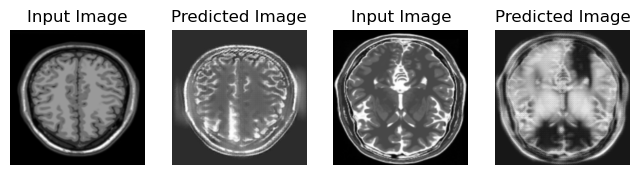

Saving checkpoint for epoch 33 at ./Trained_Model\ckpt-123


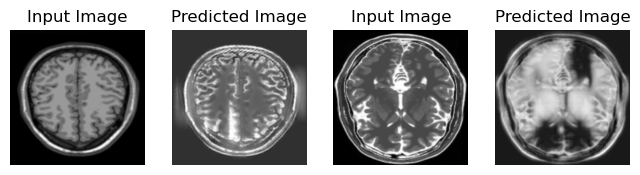

Saving checkpoint for epoch 34 at ./Trained_Model\ckpt-124


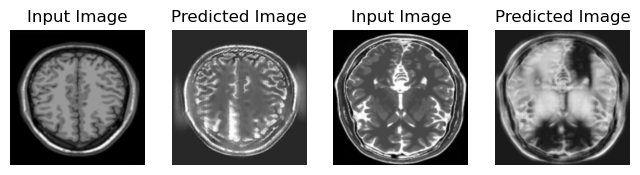

Saving checkpoint for epoch 35 at ./Trained_Model\ckpt-125


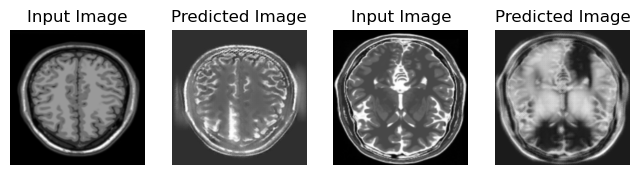

Saving checkpoint for epoch 36 at ./Trained_Model\ckpt-126


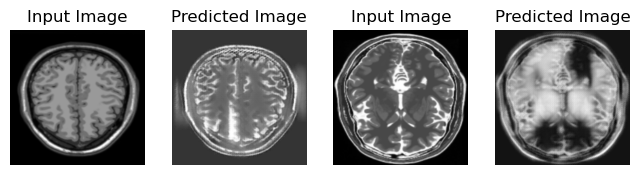

Saving checkpoint for epoch 37 at ./Trained_Model\ckpt-127


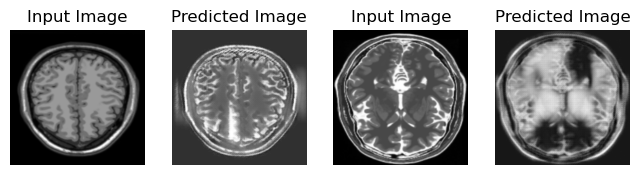

Saving checkpoint for epoch 38 at ./Trained_Model\ckpt-128


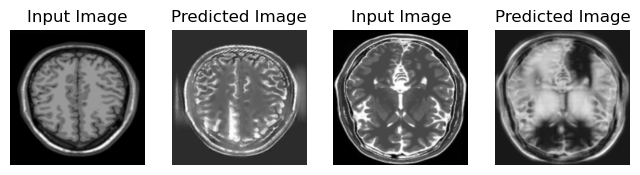

Saving checkpoint for epoch 39 at ./Trained_Model\ckpt-129


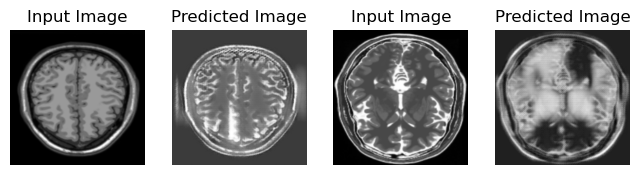

Saving checkpoint for epoch 40 at ./Trained_Model\ckpt-130


In [36]:
#Training the model
for epoch in range(1, EPOCHS+1):
    for image_x, image_y in tf.data.Dataset.zip((data_t1, data_t2)):
        train_step(image_x, image_y)
    generate_images(generator_g, sample_t1_data, generator_f, sample_t2_data)
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)